In [57]:
# !rm -rf /kaggle/working/*
# Install required packages
!pip install transformers --quiet

In [58]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18, ResNet18_Weights
from transformers import BertTokenizer, BertModel
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import zipfile
import matplotlib.image as img
%matplotlib inline

In [59]:
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())

CUDA available: True
CUDA device count: 2


# Dataset Download & Inspection

In [60]:
%cd /kaggle/input/food-101/

/kaggle/input/food-101


In [61]:
# Helper function to download data and extract
def get_data_extract():
  if "food-101" in os.listdir():
    print("Dataset already exists")
  else:
    print("Downloading the data...")
    !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
    print("Dataset downloaded!")
    print("Extracting data..")
    !tar xzvf food-101.tar.gz
    print("Extraction done!")

In [62]:
# Download data and extract it to folder
# Uncomment this below line if you are on Colab

# get_data_extract()

In [63]:
!ls food-101/food-101

images	license_agreement.txt  meta  README.txt


In [64]:
os.listdir('food-101/food-101/images')

['macarons',
 'french_toast',
 'lobster_bisque',
 'prime_rib',
 'pork_chop',
 'guacamole',
 'baby_back_ribs',
 'mussels',
 'beef_carpaccio',
 'poutine',
 'hot_and_sour_soup',
 'seaweed_salad',
 'foie_gras',
 'dumplings',
 'peking_duck',
 'takoyaki',
 'bibimbap',
 'falafel',
 'pulled_pork_sandwich',
 'lobster_roll_sandwich',
 'carrot_cake',
 'beet_salad',
 'panna_cotta',
 'donuts',
 'red_velvet_cake',
 'grilled_cheese_sandwich',
 'cannoli',
 'spring_rolls',
 'shrimp_and_grits',
 'clam_chowder',
 'omelette',
 'fried_calamari',
 'caprese_salad',
 'oysters',
 'scallops',
 'ramen',
 'grilled_salmon',
 'croque_madame',
 'filet_mignon',
 'hamburger',
 'spaghetti_carbonara',
 'miso_soup',
 'bread_pudding',
 'lasagna',
 'crab_cakes',
 'cheesecake',
 'spaghetti_bolognese',
 'cup_cakes',
 'creme_brulee',
 'waffles',
 'fish_and_chips',
 'paella',
 'macaroni_and_cheese',
 'chocolate_mousse',
 'ravioli',
 'chicken_curry',
 'caesar_salad',
 'nachos',
 'tiramisu',
 'frozen_yogurt',
 'ice_cream',
 'ris

In [65]:
os.listdir('food-101/food-101/meta')

['test.txt',
 'train.json',
 'labels.txt',
 'test.json',
 'train.txt',
 'classes.txt']

In [66]:
!head food-101/food-101/meta/train.txt

apple_pie/1005649
apple_pie/1014775
apple_pie/1026328
apple_pie/1028787
apple_pie/1043283
apple_pie/1050519
apple_pie/1057749
apple_pie/1057810
apple_pie/1072416
apple_pie/1074856


In [67]:
!head food-101/food-101/meta/classes.txt

apple_pie
baby_back_ribs
baklava
beef_carpaccio
beef_tartare
beet_salad
beignets
bibimbap
bread_pudding
breakfast_burrito


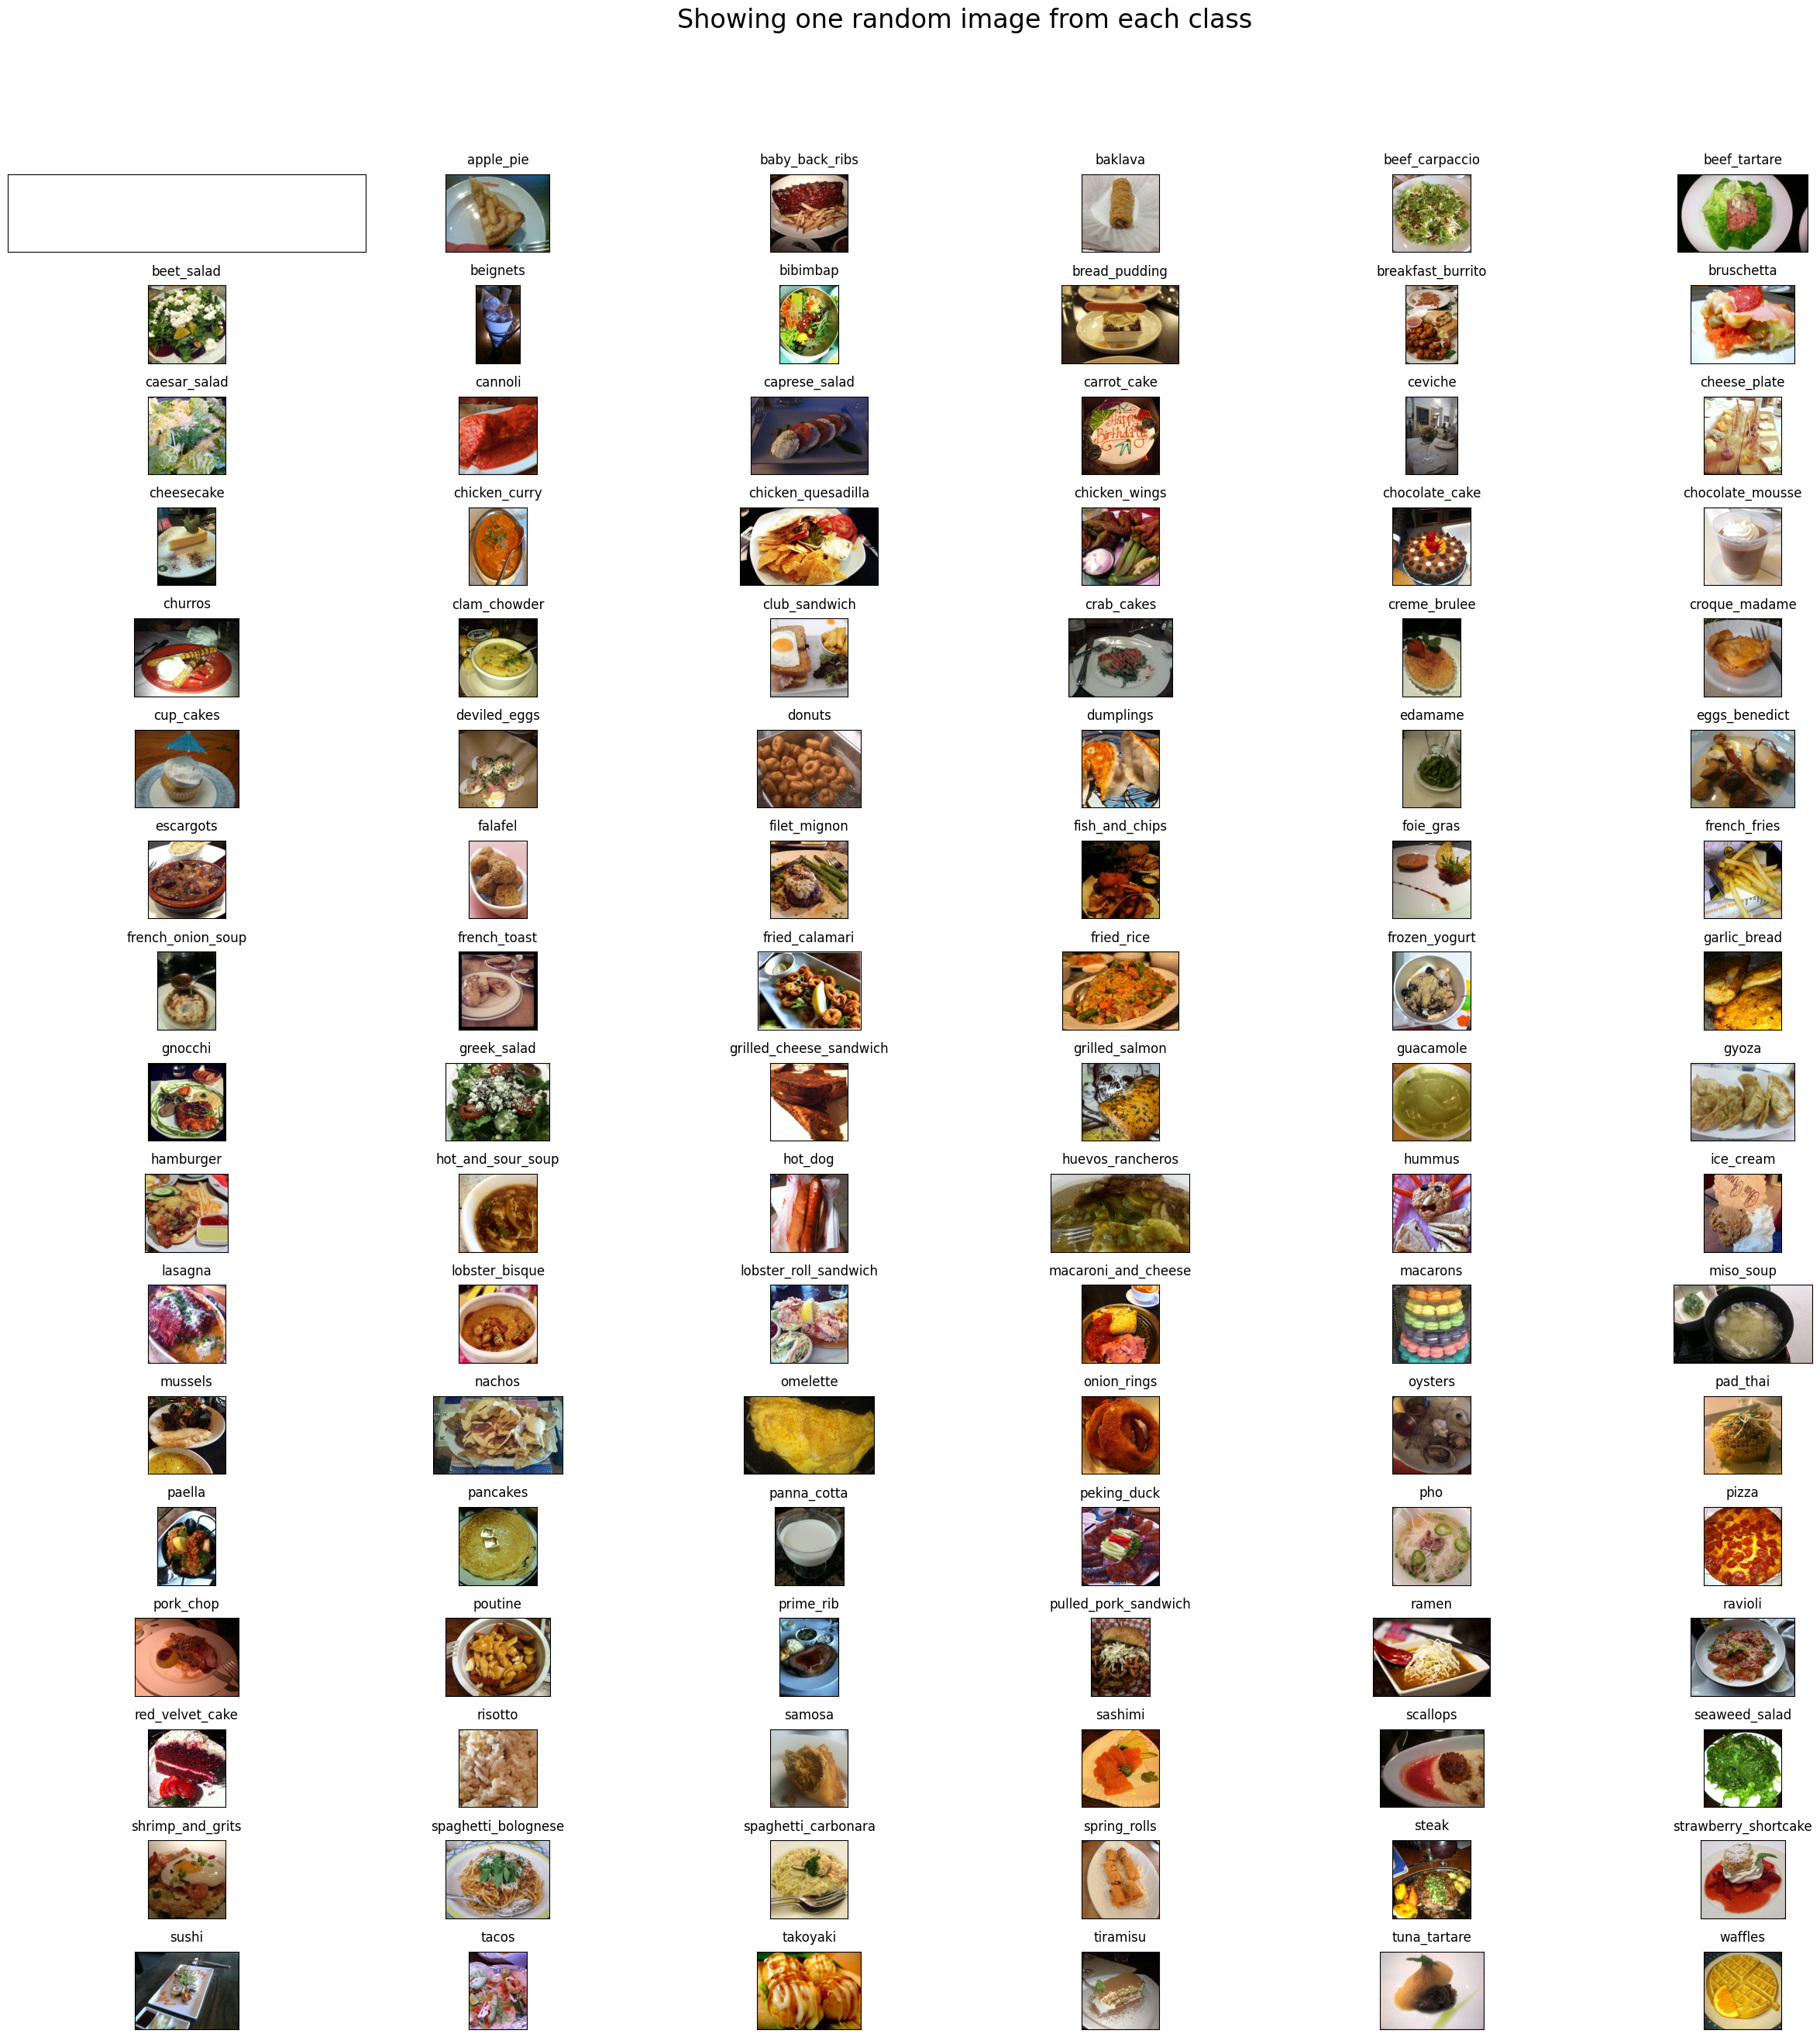

In [68]:
# Visualize the data, showing one image per class from 101 classes
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir = "food-101/food-101/images/"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id] 
      food_id += 1
    except:
      break
    if food_selected == '.DS_Store':
        continue
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)
    
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()
# https://matplotlib.org/users/tight_layout_guide.html

In [69]:
CFG = {
    "batch_size": 32,
    "lr": 3e-4,
    "epochs": 5,
    "checkpoint_dir": "/kaggle/working/checkpoints/",
    "num_classes": 101,  # Food-101 has 101 classes
    "image_size": 224,
    "max_seq_length": 128,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "dataset_percent": 0.01,  # Use 100% of data
    "image_root": "/kaggle/input/food-101/food-101/food-101/images",
    "metadata_path": "/kaggle/working/metadata.csv",
    "class_mapping_path": "/kaggle/working/class_mapping.json",
    "val_size": 0.1,
    "seed": 42
}

In [ ]:
!mkdir /kaggle/working/checkpoints

In [71]:
CFG

{'batch_size': 32,
 'lr': 0.0003,
 'epochs': 5,
 'checkpoint_dir': '/kaggle/working/checkpoints/',
 'num_classes': 101,
 'image_size': 224,
 'max_seq_length': 128,
 'device': 'cuda',
 'dataset_percent': 0.01,
 'image_root': '/kaggle/input/food-101/food-101/food-101/images',
 'metadata_path': '/kaggle/working/metadata.csv',
 'class_mapping_path': '/kaggle/working/class_mapping.json',
 'val_size': 0.1,
 'seed': 42}

In [72]:
#
def generate_metadata():
    """Create metadata CSV from Food-101 directory structure"""
    metadata = []
    class_mapping = {}

    # Get only valid class directories (exclude hidden files)
    classes = sorted([
        d for d in os.listdir(CFG['image_root']) 
        if os.path.isdir(os.path.join(CFG['image_root'], d)) 
        and not d.startswith('.')
    ])
    # Update number of classes based on actual directories
    CFG['num_classes'] = len(classes)
    print(f"Found {CFG['num_classes']} valid food classes")

    # Validate class count
    assert len(classes) == CFG['num_classes'], \
    f"Expected {CFG['num_classes']} classes, found {len(classes)}"

    for idx, cls in enumerate(classes):
        class_mapping[cls] = idx
        cls_dir = os.path.join(CFG['image_root'], cls)
        if not os.path.isdir(cls_dir):
            continue  # Skip files like .DS_Store
        for img in os.listdir(cls_dir):
            if img.endswith(".jpg"):
                # Create text description: "Image of [class]"
                text = f"Image of {cls.replace('_', ' ')}"
                metadata.append({
                    "image_path": f"{cls}/{img}",
                    "text": text,
                    "label": idx
                })
    
    # Save class mapping
    with open(CFG['class_mapping_path'], 'w') as f:
        json.dump(class_mapping, f)
    
    # Create DataFrame and split
    df = pd.DataFrame(metadata)
    train_df, val_df = train_test_split(
        df, 
        test_size=CFG['val_size'], 
        random_state=CFG['seed']
    )
    
    # Save metadata
    train_df.to_csv("/kaggle/working/train_metadata.csv", index=False)
    val_df.to_csv("/kaggle/working/val_metadata.csv", index=False)
    print(f"Generated metadata with {len(df)} samples ({len(train_df)} train, {len(val_df)} val)")

generate_metadata()

Found 101 valid food classes
Generated metadata with 101000 samples (90900 train, 10100 val)


# Dataset Class

In [73]:
class Food101Dataset(Dataset):
    def __init__(self, csv_path, transform=None, tokenizer=None, dataset_percent=1.0):
        self.df = pd.read_csv(csv_path)
        
        # Use subset of data
        if dataset_percent < 1.0:
            self.df = self.df.sample(
                frac=dataset_percent, 
                random_state=CFG['seed']
            )
        
        self.transform = transform
        self.tokenizer = tokenizer if tokenizer else BertTokenizer.from_pretrained('bert-base-uncased')
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Image processing
        img_path = os.path.join(CFG['image_root'], row['image_path'])
        try:
            image = Image.open(img_path).convert('RGB')
        except:
            # Handle corrupt images
            image = Image.new('RGB', (CFG['image_size'], CFG['image_size']), color='black')
        
        if self.transform:
            image = self.transform(image)
        
        # Text processing
        text = self.tokenizer(
            row['text'],
            padding='max_length',
            max_length=CFG['max_seq_length'],
            truncation=True,
            return_tensors="pt"
        )
        text = {k: v.squeeze(0) for k, v in text.items()}
        
        label = torch.tensor(row['label'])
        return image, text, label

# Model

In [74]:
# Multimodal Transformer Model
class FoodClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Image encoder
        self.img_encoder = resnet18(weights=ResNet18_Weights.DEFAULT)
        self.img_encoder.fc = nn.Identity()
        self.img_proj = nn.Linear(512, 768)  # Project to text dimension
        
        # Text encoder
        self.text_encoder = BertModel.from_pretrained('bert-base-uncased')
        
        # Fusion transformer
        self.fusion = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=768, nhead=8, batch_first=True),
            num_layers=2
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, img, text):
        # Image features
        img_feats = self.img_encoder(img)
        img_feats = self.img_proj(img_feats).unsqueeze(1)  # [batch, 1, 768]
        
        # Text features
        text_feats = self.text_encoder(
            input_ids=text['input_ids'],
            attention_mask=text['attention_mask']
        ).last_hidden_state
        
        # Combine features
        combined = torch.cat([img_feats, text_feats], dim=1)
        fused = self.fusion(combined)
        
        # Classification
        return self.classifier(fused[:, 0, :])  # Use image token


## Training and Validation

In [75]:
# Training and Validation Functions
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    progress = tqdm(loader, desc="Training", leave=False)
    
    for images, texts, labels in progress:
        images = images.to(device)
        texts = {k: v.to(device) for k, v in texts.items()}
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images, texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * images.size(0)
        progress.set_postfix(loss=loss.item())
    
    return total_loss / len(loader.dataset)

def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        progress = tqdm(loader, desc="Validation", leave=False)
        for images, texts, labels in progress:
            images = images.to(device)
            texts = {k: v.to(device) for k, v in texts.items()}
            labels = labels.to(device)
            
            outputs = model(images, texts)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)
            
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
            progress.set_postfix(acc=correct/total if total > 0 else 0)
    
    avg_loss = total_loss / len(loader.dataset) if len(loader.dataset) > 0 else 0
    accuracy = correct / total if total > 0 else 0
    return avg_loss, accuracy


## Run Train

In [76]:
def train():
    device = torch.device(CFG['device'])
    print(f"Using device: {device}")
    
    # Load class mapping
    with open(CFG['class_mapping_path'], 'r') as f:
        class_mapping = json.load(f)
    
    # Transforms with augmentation
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(CFG['image_size'], scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(CFG['image_size']),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # Tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    
    # Create datasets
    train_dataset = Food101Dataset(
        csv_path="/kaggle/working/train_metadata.csv",
        transform=train_transform,
        tokenizer=tokenizer,
        dataset_percent=CFG['dataset_percent']
    )
    
    val_dataset = Food101Dataset(
        csv_path="/kaggle/working/val_metadata.csv",
        transform=val_transform,
        tokenizer=tokenizer,
        dataset_percent=min(CFG['dataset_percent'], 0.5)  # Max 50% for validation
    )
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=CFG['batch_size'], 
        shuffle=True, 
        num_workers=2,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=CFG['batch_size'], 
        shuffle=False, 
        num_workers=2,
        pin_memory=True
    )
    
    # Initialize model
    model = FoodClassifier(CFG['num_classes']).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=CFG['lr'], weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=2, verbose=True
    )
    
    # Training state
    best_accuracy = 0.0
    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}
    
    # Training loop
    for epoch in range(CFG['epochs']):
        print(f"\nEpoch {epoch+1}/{CFG['epochs']}")
        
        # Train phase
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        history['train_loss'].append(train_loss)
        
        # Validation phase
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        scheduler.step(val_acc)
        
        # Save best checkpoint
        if val_acc > best_accuracy:
            best_accuracy = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'config': CFG
            }, os.path.join(CFG['checkpoint_dir'], 'best_model.pth'))
            print(f"New best model saved with accuracy: {val_acc:.4f}")
        
        # Save latest checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'config': CFG
        }, os.path.join(CFG['checkpoint_dir'], 'latest_model.pth'))
        
        # Save training history
        history_path = os.path.join(CFG['checkpoint_dir'], 'training_history.json')
        with open(history_path, 'w') as f:
            json.dump(history, f)
            
        # Print epoch summary
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    print("\nTraining complete!")
    print(f"Best validation accuracy: {best_accuracy:.4f}")
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss History')
    
    plt.subplot(1, 2, 2)
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy History')
    plt.savefig(os.path.join(CFG['checkpoint_dir'], 'training_history.png'))
    plt.show()


Using device: cuda

Epoch 1/5


New best model saved with accuracy: 0.3861
Train Loss: 4.2845 | Val Loss: 3.4102 | Val Acc: 0.3861

Epoch 2/5


New best model saved with accuracy: 0.8317
Train Loss: 2.0487 | Val Loss: 1.1204 | Val Acc: 0.8317

Epoch 3/5


New best model saved with accuracy: 0.9505
Train Loss: 0.4885 | Val Loss: 0.3585 | Val Acc: 0.9505

Epoch 4/5


Train Loss: 0.1201 | Val Loss: 0.2487 | Val Acc: 0.9406

Epoch 5/5


Train Loss: 0.1374 | Val Loss: 0.2744 | Val Acc: 0.9406

Training complete!
Best validation accuracy: 0.9505


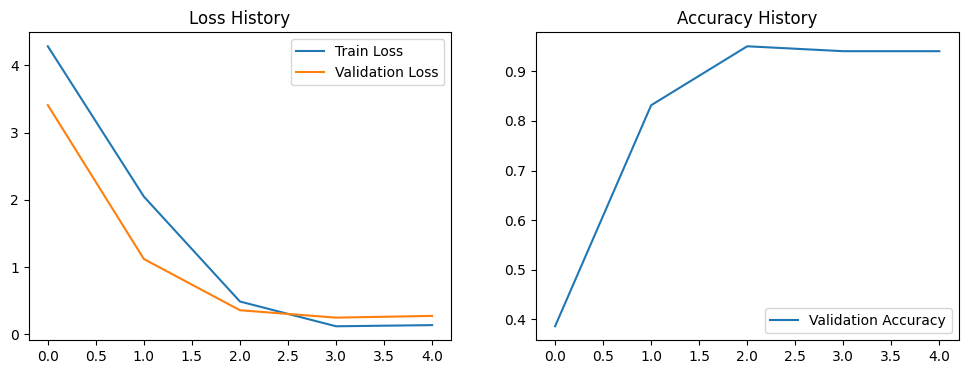

In [77]:
train()

# Inference with Best Model

In [78]:
def run_inference(image_path, text_description=None):
    """Run inference on a single image-text pair"""
    device = torch.device(CFG['device'])
    
    # Load class mapping
    with open(CFG['class_mapping_path'], 'r') as f:
        class_mapping = json.load(f)
    idx_to_class = {v: k for k, v in class_mapping.items()}
    
    # Load model
    model = FoodClassifier(CFG['num_classes']).to(device)
    checkpoint = torch.load(os.path.join(CFG['checkpoint_dir'], 'best_model.pth'))
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    # Prepare transforms
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(CFG['image_size']),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # Load tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    
    # Process image
    try:
        image = Image.open(image_path).convert('RGB')
    except:
        print(f"Could not load image at {image_path}")
        return None
    
    image = transform(image).unsqueeze(0).to(device)
    
    # Process text (use provided text or default)
    if text_description is None:
        # Extract class name from path if possible
        class_name = os.path.dirname(image_path).split('/')[-1]
        text = f"Image of {class_name.replace('_', ' ')}" if class_name else "Image of food"
    else:
        text = text_description
    
    text = tokenizer(
        text,
        padding='max_length',
        max_length=CFG['max_seq_length'],
        truncation=True,
        return_tensors="pt"
    )
    text = {k: v.to(device) for k, v in text.items()}
    
    # Run prediction
    with torch.no_grad():
        outputs = model(image, text)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        top_probs, top_classes = torch.topk(probs, 5)
    
    # Convert to human-readable results
    results = []
    for i in range(top_probs.shape[1]):
        class_idx = top_classes[0][i].item()
        results.append({
            'class': idx_to_class[class_idx].replace('_', ' '),
            'probability': f"{top_probs[0][i].item()*100:.2f}%"
        })
    
    # Display results
    plt.imshow(Image.open(image_path))
    plt.axis('off')
    plt.title(f"Input: {os.path.basename(image_path)}")
    plt.show()
    
    print("\nTop 5 Predictions:")
    for i, res in enumerate(results, 1):
        print(f"{i}. {res['class']}: {res['probability']}")
    
    return results

## Random image from validation set

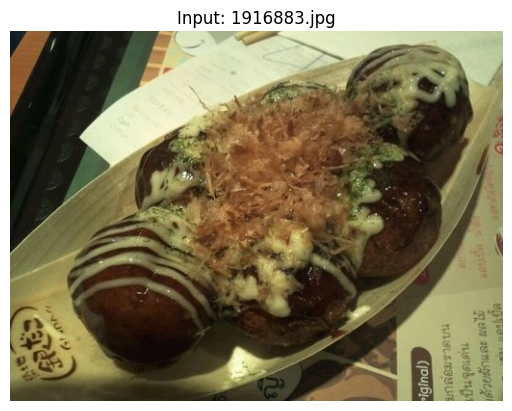


Top 5 Predictions:
1. takoyaki: 71.10%
2. guacamole: 2.95%
3. samosa: 1.95%
4. fried calamari: 1.60%
5. steak: 1.14%


In [79]:
# Example usage - pick a random image from validation set
val_df = pd.read_csv("/kaggle/working/val_metadata.csv")
sample = val_df.sample(1).iloc[0]

# Run inference
results = run_inference(
    image_path=os.path.join(CFG['image_root'], sample['image_path']),
    text_description=sample['text']
)

In [80]:
!ls /kaggle/working

checkpoints  class_mapping.json  train_metadata.csv  val_metadata.csv


## Package results

In [81]:
# Package results
!zip -r /kaggle/working/results.zip /kaggle/working/checkpoints /kaggle/working/*.csv

  adding: kaggle/working/checkpoints/ (stored 0%)
  adding: kaggle/working/checkpoints/training_history.json (deflated 46%)
  adding: kaggle/working/checkpoints/latest_model.pth (deflated 19%)
  adding: kaggle/working/checkpoints/training_history.png (deflated 9%)
  adding: kaggle/working/checkpoints/best_model.pth (deflated 19%)
  adding: kaggle/working/train_metadata.csv (deflated 80%)
  adding: kaggle/working/val_metadata.csv (deflated 80%)
